In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Data

In [25]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch

from torch import nn
from torch.nn import functional as F
from pathlib import Path
from tqdm import tqdm
from CSLS import eval_alignment_by_sim_mat
from matplotlib import pyplot as plt

DATA_PATH = Path('TEA-GNN/data/ICEWS05-15')
os.listdir(DATA_PATH)

['rel_ids_1',
 'sup_pairs',
 'rel_ids_2',
 'ref_pairs',
 'ent_ids_2',
 'triples_2',
 'ent_ids_1',
 'triples_1']

In [3]:
def create_triples(ent_file, rel_file, triple_file, times=False):
    df_ent_1 = pd.read_csv(ent_file, delimiter='\t', header=None, names=['id', 'entity'], index_col=0)
    df_rel_1 = pd.read_csv(rel_file, delimiter='\t', header=None, names=['relation', 'id'], index_col=1)
    
    if times:
        df_triples_1 = pd.read_csv(triple_file, delimiter='\t', header=None, names=['head', 'relation', 'tail', 'time_start', 'time_end'])
    else:
        df_triples_1 = pd.read_csv(triple_file, delimiter='\t', header=None, names=['head', 'relation', 'tail', 'time'])
    
    df_trip_ent = df_triples_1.set_index('head').join(df_ent_1, rsuffix='_head').reset_index().rename(columns={'index': 'head', 'entity': 'entity_head'})
    df_trip_ent = df_trip_ent.set_index('tail').join(df_ent_1).reset_index().rename(columns={'index': 'tail', 'entity': 'entity_tail'})
    df_trip_ent = df_trip_ent.set_index('relation').join(df_rel_1).reset_index().rename(columns={'index': 'relation', 'relation': 'rel'})
    
    
    entities = set(df_trip_ent['head'].unique().tolist() + df_trip_ent['tail'].unique().tolist())
    relations = set([0, *(df_trip_ent['relation'].unique() + 1)])
    times = set([0, *(df_trip_ent['time'].unique() + 1)])
    triples = df_trip_ent[['head', 'relation', 'tail', 'time']].to_numpy().tolist()

    return entities, relations, times, triples

def load_alignments(align_file):
    return pd.read_csv(align_file, delimiter='\t', header=None, names=['entity_1', 'entity_2']).to_numpy().tolist()

In [4]:
### message passing matrix

def normalize_adj(adj):
    adj = sp.coo_matrix(adj)
    ## creating the degree matrix = D
    rowsum = np.array(adj.sum(1))  
    d_inv_sqrt = np.power(rowsum, -0.5).flatten() 
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    ##
    return d_mat_inv_sqrt.dot(adj).transpose().dot(d_mat_inv_sqrt).T # creating the adj matrix for message passing


In [5]:
entities_1, relations_1, times_1, triples_1 = create_triples(DATA_PATH/'ent_ids_1', DATA_PATH/'rel_ids_1', DATA_PATH/'triples_1')
entities_2, relations_2, times_2, triples_2 = create_triples(DATA_PATH/'ent_ids_2', DATA_PATH/'rel_ids_2', DATA_PATH/'triples_2')
train_alignments = load_alignments(DATA_PATH/'ref_pairs')
dev_alignments = load_alignments(DATA_PATH/'sup_pairs')
all_ent, all_rel, all_times, all_triples = entities_1.union(entities_2), relations_1.union(relations_2), times_1.union(times_2), triples_1 + triples_2

In [6]:
len(dev_alignments)

1000

In [7]:
def get_matrix(all_ent, all_rel, all_times, all_triples):
    ent_size = max(all_ent) + 1
    rel_size = max(all_rel) + 1
    time_size = max(all_times) + 1

    adj_matrix = sp.lil_matrix((ent_size, ent_size))
    adj_features = sp.lil_matrix((ent_size, ent_size))
    radj = []

    rel_in = np.zeros((ent_size, rel_size))
    rel_out = np.zeros((ent_size, rel_size))

    for i in range(ent_size):
        adj_features[i, i] = 1

    time_link = np.zeros((ent_size, time_size))

    for h, r, t, tau in all_triples:
        adj_matrix[h, t] = 1; adj_matrix[t, h] = 1
        adj_features[h, t] = 1; adj_features[t, h] = 1
        radj.append([h, t, r, tau]); radj.append([t, h, r + rel_size, tau])
        time_link[h, tau] += 1; time_link[t, tau] += 1
        rel_out[h, r] += 1; rel_in[t, r] += 1

    count = -1
    s = set()
    d = {}
    r_index, t_index, r_val = [], [], []

    for h, t, r, tau in sorted(radj, key = lambda x: x[0] * 10e10 + x[1]*10e5):
        if ' '.join([str(h), str(t)]) in s:
            r_index.append([count, r])
            t_index.append([count, tau])
            r_val.append(1)
            d[count] += 1
        else:
            count += 1
            d[count]  = 1
            s.add(' '.join([str(h), str(t)]))
            r_index.append([count, r])
            t_index.append([count, tau])
            r_val.append(1)
    for i in range(len(r_index)):
        r_val[i] /= d[r_index[i][0]]

    time_features = time_link

    time_features = normalize_adj(sp.lil_matrix(time_features)) #### using time as an averager for the node features

    rel_features = np.concatenate([rel_in, rel_out], axis=1)
    rel_features = normalize_adj(rel_features)  ### use relations as an averager for the node features
    adj_features = normalize_adj(adj_features)
    
    return adj_matrix, np.array(r_index), np.array(r_val), np.array(t_index), adj_features, rel_features, time_features

In [8]:
## r_index => [unique head and tail, relation index numbers]
## t_index => [unique head and tail, time index numbers]
## r_val ==> equal weight for the unique head and tail over all relations/timestamps

adj_matrix, r_index, r_val, t_index, adj_features, rel_features, time_features = get_matrix(all_ent, all_rel, all_times, all_triples)
adj_matrix = np.stack(adj_matrix.nonzero(), axis=1) ## all indices where there is "some kind of adjancent relation"
rel_matrix, rel_val = np.stack(rel_features.nonzero(), axis=1), rel_features.data ## Nodes x Relation array
ent_matrix, ent_val = np.stack(adj_features.nonzero(), axis=1), adj_features.data
time_matrix, time_val = np.stack(time_features.nonzero(), axis=1), time_features.data

node_size = adj_features.shape[0]
rel_size = rel_features.shape[1]
time_size = time_features.shape[1]
triple_size = len(adj_matrix)
batch_size = node_size
node_size, rel_size, time_size, triple_size, batch_size

(19054, 988, 4018, 198262, 19054)

In [9]:
outputs = [np.expand_dims(i, axis=0) for i in [adj_matrix, r_index, r_val, t_index, adj_features, rel_features, time_features]]
adj_matrix, r_index, r_val, t_index, adj_features, rel_features, time_features = outputs

In [10]:
adj_matrix.shape, r_index.shape, r_val.shape, adj_features.shape, rel_features.shape, time_features.shape

((1, 198262, 2), (1, 1230210, 2), (1, 1230210), (1,), (1,), (1,))

In [11]:
ent_dim, rel_dim, time_dim = 128, 128, 128

In [12]:
device = 'cuda:1'
class ContextualEmbedding(nn.Module):
    def __init__(self, inp_dim, out_dim=128, other_dim=None):
        super(ContextualEmbedding, self).__init__()
        self.inp_dim = inp_dim
        self.out_dim = out_dim
        self.other_dim = other_dim if other_dim is not None else inp_dim
        self.embedding = nn.Embedding(self.other_dim, self.out_dim)
        
    def forward(self, indices):
        x = self.embedding(torch.arange(self.other_dim).long().to(device))
        size = (self.inp_dim, self.other_dim)
        indices = torch.sparse_coo_tensor(indices, values=torch.ones_like(indices[0, :], dtype=torch.float32), size=size)
        indices = torch.sparse.softmax(indices, dim=len(indices.size())-1)
        return torch.sparse.mm(indices, x)

In [13]:
ent_sparse = torch.tensor(np.array([ent_matrix[:, 1], ent_matrix[:, 0]])).long().to(device)
rel_sparse = torch.tensor(np.array([rel_matrix[:, 1], rel_matrix[:, 0]])).long().to(device)
time_sparse = torch.tensor(np.array([time_matrix[:, 1], time_matrix[:, 0]])).long().to(device)

In [14]:
class HeteroTimeGAT(nn.Module):
    def __init__(self, adj, emb_size):
        super(HeteroTimeGAT, self).__init__()
        self.attend_relation = nn.Linear(emb_size * 3, 1)
        self.attend_time = nn.Linear(emb_size * 3, 1)
        self.adj = adj
        
    def forward(self, xr, xt, selfs, neighs):
        indices = self.adj.coalesce().indices()
        rel_x = self.attend_relation(xr).view(-1)
        rel_x = torch.sparse_coo_tensor(indices, rel_x, self.adj.shape)
        rel_x = torch.sparse.softmax(rel_x, 1)
        att_rel_x = neighs * rel_x.coalesce().values().unsqueeze(-1)
        
        time_x = self.attend_time(xt).view(-1)
        time_x = torch.sparse_coo_tensor(indices, time_x, self.adj.shape)
        time_x = torch.sparse.softmax(time_x, 1)
        att_time_x = neighs * time_x.coalesce().values().unsqueeze(-1)
        
        return att_rel_x, att_time_x

In [15]:
def get_train_set(batch_size = batch_size):
    negative_ratio =  batch_size // len(train_alignments) + 1
    train_set = np.reshape(np.repeat(np.expand_dims(train_alignments,axis=0),axis=0,repeats=negative_ratio),newshape=(-1,2))
    np.random.shuffle(train_set); train_set = train_set[:batch_size]
    train_set = np.concatenate([train_set,np.random.randint(0,node_size,train_set.shape)],axis = -1)
    return train_set
    
class FullModel(nn.Module):
    def __init__(self, adj, node_size, rel_size, time_size, triple_size, ent_sparse, rel_sparse, time_sparse, emb_size=128, depth=1, device='cuda'):
        super(FullModel, self).__init__()

        self.device = device
        self.node_size = node_size
        self.rel_size = rel_size
        self.time_size = time_size
        self.triple_size = triple_size
        self.emb_size = emb_size
        self.depth = depth
        self.adj = adj
        self.indices = self.adj.coalesce().indices()
        self.indices_size = self.indices.size(1)
        self.activation = nn.ReLU()
        
        self.ent_embedding = ContextualEmbedding(self.node_size, self.emb_size).to(self.device)
        self.rel_embedding = ContextualEmbedding(self.rel_size, self.emb_size, self.node_size).to(self.device)
        self.time_embedding = ContextualEmbedding(self.time_size, self.emb_size, self.node_size).to(self.device)
        
        self.attend_relation = nn.Linear(emb_size * 3, 1)
        self.attend_time = nn.Linear(emb_size * 3, 1)
        
        self.dropout = nn.Dropout(0.3)
#         self.graph_net = TNR_GraphAttention(adj, node_size, rel_size, time_size, triple_size, emb_size, depth, device)
        self.ent_emb = self.ent_embedding(ent_sparse).to(self.device)
        self.rel_emb = self.rel_embedding(rel_sparse).to(self.device)
        self.time_emb = self.time_embedding(time_sparse).to(self.device)
    
    def forward(self, inputs):
        r_index_sq, r_val_sq, t_index_sq = inputs
        self.neighs, self.selfs = self.ent_emb[self.indices.T[:, 1]], self.ent_emb[self.indices.T[:, 0]]
        
        outputs = []
        features = self.activation(self.ent_emb)
        node_size = self.node_size
        
        outputs.append(features)
        
        for i in range(self.depth):
            
            rels_sum = torch.sparse_coo_tensor(r_index_sq.T, r_val_sq, (self.triple_size, self.rel_size)).to(self.device)
            rels_sum = torch.sparse.mm(rels_sum.float(), self.rel_emb)
            rels_sum_n = torch.nn.functional.normalize(rels_sum, 2)
            r_neighs = self.neighs - 2 * torch.sum(self.neighs * rels_sum_n, 1, keepdims=True) * rels_sum_n
            r_concat = torch.cat([self.selfs, self.neighs, rels_sum_n], axis=1)
            
            times_sum = torch.sparse_coo_tensor(t_index_sq.T, r_val_sq, (triple_size, time_size)).to(self.device)
            times_sum = torch.sparse.mm(times_sum.float(), self.time_emb)
            times_sum_n = torch.nn.functional.normalize(times_sum, 2)
            t_neighs = self.neighs - 2 * torch.sum(self.neighs * times_sum_n, 1, keepdims=True) * times_sum_n
            t_concat = torch.cat([self.selfs, self.neighs, times_sum_n], axis=1)
            
            indices = self.adj.coalesce().indices()
            rel_x = self.attend_relation(r_concat).view(-1)
            rel_x = torch.sparse_coo_tensor(indices, rel_x, self.adj.shape)
            rel_x = torch.sparse.softmax(rel_x, 1)
            att_rel_x = self.neighs * rel_x.coalesce().values().unsqueeze(-1)

            time_x = self.attend_time(t_concat).view(-1)
            time_x = torch.sparse_coo_tensor(indices, time_x, self.adj.shape)
            time_x = torch.sparse.softmax(time_x, 1)
            att_time_x = self.neighs * time_x.coalesce().values().unsqueeze(-1)

            indices = torch.stack([self.indices[0, :], torch.arange(self.indices[0, :].size(0)).to(self.device)])
            
            th = torch.sparse_coo_tensor(indices, torch.ones_like(indices[0]), (node_size, self.indices[0, :].size(0)))
            new_r = torch.sparse.mm(th.float(), att_rel_x)
            new_t = torch.sparse.mm(th.float(), att_time_x)
            
            new_features = new_r + new_t
            
            features = self.activation(new_features)
            outputs.append(features)
            
        ent_encoding = torch.cat(outputs, 1)
        
        times_sum = torch.sparse_coo_tensor(t_index_sq.T, r_val_sq, (self.triple_size, self.time_size)).to(device)
        times_sum_n = torch.sparse.mm(times_sum.float(), self.time_emb)
        new_indices = torch.vstack([self.adj.coalesce().indices()[0, :], torch.arange(self.adj.coalesce().indices()[0, :].size(0)).to(device)])
        time_indices = torch.sparse_coo_tensor(new_indices, torch.ones_like(new_indices[0]), (self.node_size, new_indices[0, :].size(0)))
        time_encoding = self.activation(torch.sparse.mm(time_indices.float(), times_sum_n))
        
        
        return self.dropout(torch.cat([ent_encoding, time_encoding], 1))

adj_sparse_pre = torch.tensor(adj_matrix).squeeze(0).long()
adj_sparse = torch.sparse_coo_tensor(adj_sparse_pre.T, torch.ones_like(adj_sparse_pre[:, 0]), (node_size, node_size)).to(device)
ent_sparse = torch.tensor(np.array([ent_matrix[:, 1], ent_matrix[:, 0]])).long().to(device)
rel_sparse = torch.tensor(np.array([rel_matrix[:, 1], rel_matrix[:, 0]])).long().to(device)
time_sparse = torch.tensor(np.array([time_matrix[:, 1], time_matrix[:, 0]])).long().to(device)
r_index_sq, r_val_sq, t_index_sq = r_index.squeeze(0), r_val.squeeze(0), t_index.squeeze(0)
alignment_pairs = get_train_set()

model = FullModel(adj_sparse, node_size, rel_size, time_size, triple_size, ent_sparse, rel_sparse, time_sparse, depth=2, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1, weight_decay=0.01)


def l1(ll, rr):
        return torch.sum(torch.abs(ll - rr), axis=-1)
gamma = 1.0
losses = []
t_prec = []
accs = []
t_mrrs = []
for i in tqdm(range(100)):
    model.train()
    optimizer.zero_grad()
    features = model((r_index_sq, r_val_sq, t_index_sq))
    comp = features[alignment_pairs]
    l, r, fl, fr = comp[:, 0, :], comp[:, 1, :], comp[:, 2, :], comp[:, 3, :]
    loss = torch.sum(nn.ReLU()(gamma + l1(l, r) - l1(l, fr)) + nn.ReLU()(gamma + l1(l, r) - l1(fl, r))) / batch_size
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
    if ((i + 1) % 10) == 0:
        model.eval()
        with torch.no_grad():
            feat = model((r_index_sq, r_val_sq, t_index_sq))[dev_alignments]
            Lvec = np.array(feat[:, 0, :].cpu()) #np.array([vec[e1] for e1, e2 in feat])
            Rvec = np.array(feat[:, 1, :].cpu()) #np.array([vec[e2] for e1, e2 in dev_alignments])
            Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
            Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)
            t_prec_set, acc, t_mrr = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], 1, csls=10, accurate = True)
            accs.append(acc)
            t_mrrs.append(t_mrr)
            t_prec.append(t_prec_set)

 10%|█         | 10/100 [00:06<01:15,  1.19it/s]

accurate results: hits@[1, 5, 10] = [53.4 65.8 71.6], mr = 50.431, mrr = 0.593, time = 1.380 s 


 20%|██        | 20/100 [00:10<01:03,  1.25it/s]

accurate results: hits@[1, 5, 10] = [75.  82.5 85. ], mr = 26.447, mrr = 0.785, time = 1.263 s 


 30%|███       | 30/100 [00:15<00:57,  1.21it/s]

accurate results: hits@[1, 5, 10] = [85.  90.5 92.1], mr = 12.570, mrr = 0.875, time = 1.371 s 


 40%|████      | 40/100 [00:20<00:48,  1.24it/s]

accurate results: hits@[1, 5, 10] = [87.8 93.  94.3], mr = 6.505, mrr = 0.902, time = 1.342 s 


 50%|█████     | 50/100 [00:24<00:35,  1.40it/s]

accurate results: hits@[1, 5, 10] = [89.4 94.  95.1], mr = 5.585, mrr = 0.916, time = 1.087 s 


 60%|██████    | 60/100 [00:28<00:29,  1.35it/s]

accurate results: hits@[1, 5, 10] = [89.3 93.6 95.7], mr = 5.605, mrr = 0.915, time = 1.141 s 


 70%|███████   | 70/100 [00:33<00:23,  1.29it/s]

accurate results: hits@[1, 5, 10] = [90.2 94.1 95.5], mr = 4.648, mrr = 0.921, time = 1.244 s 


 80%|████████  | 80/100 [00:37<00:14,  1.35it/s]

accurate results: hits@[1, 5, 10] = [89.6 93.8 95.2], mr = 4.255, mrr = 0.916, time = 1.140 s 


 90%|█████████ | 90/100 [00:42<00:07,  1.27it/s]

accurate results: hits@[1, 5, 10] = [89.3 94.  95.2], mr = 4.715, mrr = 0.915, time = 1.317 s 


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

accurate results: hits@[1, 5, 10] = [89.3 93.8 95.3], mr = 5.869, mrr = 0.913, time = 1.141 s 


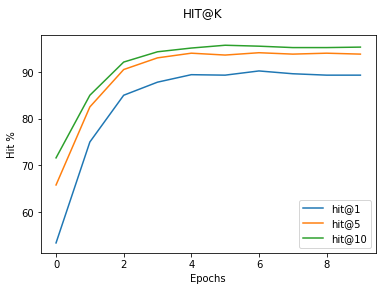

In [42]:
fig = plt.figure()
plt.plot(np.array(accs)[:, 0], label='hit@1')
plt.plot(np.array(accs)[:, 1], label='hit@5')
plt.plot(np.array(accs)[:, 2], label='hit@10')
fig.suptitle('HIT@K')
plt.xlabel('Epochs')
plt.ylabel('Hit %')
plt.legend()

Text(0, 0.5, 'Hit %')

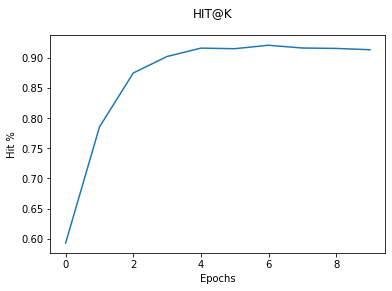

In [47]:
fig = plt.figure()
plt.plot(t_mrrs, label='t_mmr')
fig.suptitle('HIT@K')
plt.xlabel('Epochs')
plt.ylabel('Hit %')

Text(0, 0.5, 'Loss')

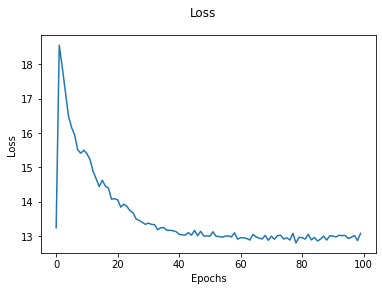

In [48]:
# losses.append(loss.item())
fig = plt.figure()
plt.plot(losses)
fig.suptitle('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
